<a href="https://colab.research.google.com/github/oscarserc/TESIS/blob/main/PASO_2____Generacion_de_Base_de_Datos_con_interacciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**GENERACIÓN de una BASE DE DATOS con las interacciones de la Red Social:** La base de datos nos permitirá emplear procedimientos de Aprendizaje Automático (Machine Learning).




#**1). Cargamos algunas librerías empleadas en la creación de agentes y fijamos los valores de los parámetros.**

In [ ]:

# Importamos las LIBRERÍAS
import numpy as np
import pandas as pd
import random

# En primer lugar procedemos a especificar los parámetros que se emplearán a lo largo del
# PROGRAMA
# =======================================================================================
# PARÁMETROS
# ----------
alfa    = 0.1     # TASA DE APRENDIZAJE
gamma   = 0.1     # TASA DE DESCUENTO
epsilon = 0.01    # probabilidad de EXPLORACIÓN    #----> PRIMERO PUSE 0.2
num_estados  = 4  # EMOCIONES - Pongo 4: Alegría, Tristeza, Ira, Miedo 
num_acciones = 2  # Cooperar o NoCooperar

# Recompensas intrínsecas
r_alegria      = 1       # Quizás poner 1, (2 parece un poco arbitrario)
r_ira          = 1
r_tristeza     = 1
r_miedo        = 1
beta           = 0.5

# TAMAÑOS POBLACIONALES (Inicialmente ponemos todos AGENTES EMOCIONALES)
probabilidad_clases = np.zeros(3)
# Para la experimentación con TRAIDORES poner un parámetro 'p' por ejemplo, y hacerlo recorrer el intervalo
#     p in (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)
#            probabilidad_clases[0] = 1 - p
#            probabilidad_clases[1] = p
probabilidad_clases[0] = 0.25   # Primer punto de corte > Si es menor que: 100 deja hueco por encima a  TRAIDOR  INGENUO  Tit-for-Tat
probabilidad_clases[1] = 0.75   #                         Por encima:                                      -     INGENUO  Tit-for-Tat
probabilidad_clases[2] = 0.0    #                         Por encima:                                      -        -     Tit-for-Tat

# TAMAÑO DE LA CUADRICULA (Grid) - Por ejemplo: (size=10)  =>  (10 filas x 10 columnas)
size = 10 # 20

# COMPROBACIÓN DE SEGURIDAD: Voy a ver si los objetos son alterados 
LISTA_IDs      = []
# -----------------------------------------------------------------

LISTA_MUTANTES = []
LISTA_NODOS_VECINOS = []
MATRIZ_ADYACENCIA_Red_Social = np.zeros((size*size + 1, size*size + 1))


#**2). Definimos las clases de los AGENTES que intervienen en el programa**

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Jerarquia_Objetos_Agente_1a.png?raw=true' width="600"/>
<figcaption></figcaption></center>
</figure>

Partimos de un AGENTE EMOCIONAL. Es el objeto principal, y a partir de él creamos otros 3 tipos de Agentes MUTANTES, que toman decisiones como un Autómata Celular.

#A) CLASE AGENTE EMOCIONAL

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4B_GLOBAL_A%C3%B1ado_Miedo_2.png?raw=true' width="700"/>
<figcaption></figcaption></center>
</figure>

Las EMOCIONES que gobiernan la toma de decisiones del agentes podemos analizarlas separadamente. En color amarillo vemos el tipo de transiciones emocionales a las que se enfrenta el AGENTE, según la decisión de su oponente (*en linea discontinua*) partiendo de su propia decisión (*en linea continua*). A continuación aparece el gráfico asociado a las emociones MIEDO e IRA.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4B_IRA_Marco.png?raw=true' width="430"/>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4B_MIEDO_Marco_2.png?raw=true' width="470"/>
<figcaption></figcaption></center>
</figure>

Las transiciones asociadas a las emociones TRISTEZA y ALEGRÍA aparecen a continuación.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4_TRISTEZA_Marco.png?raw=true' width="430"/>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/grafo_4_ALEGRIA_Marco.png?raw=true' width="470"/>
<figcaption></figcaption></center>
</figure>



In [ ]:

# CLASE PRINCIPAL
# ===============

# 1) Clase AGENTE EMOCIONAL >>> Primera prueba: (Agente con exploración epsilon-greedy)
# -------------------------

class AgenteEmocional(object):
  def __init__(self, alfa=0.1, gamma=0.1):
     self.alfa     = alfa
     self.gamma    = gamma
     self.estados  = num_estados
     self.acciones = num_acciones
     self.MUTANTE               = 0  
     self.TRAICIONADO           = 0  # A cero mientras no sea traicionado
     self.num_vecinos           = 0
     self.Numero_nodo           = 0
     self.lista_nodos_vecinos   = [] # Preparo para distribuir pagos a todos los jugadores que intervienen en la jugada
     self.lista_vecinos_grid    = [] # y para crear una MATRIZ de ADYACENCIA y dibujar un grafo de la Red-Grid
     
     # RECOMPENSAS y GANANCIAS
     # -----------------------
     self.recompensa            = 0
     self.recompensa_intrinseca = 0
     self.ganancias             = []
     self.ganancias_acumuladas  = []
     
     # ESTADOS EMOCIONALES (S y S')                 # AQUÍ ALEATORIZAMOS LA EMOCIÓN INICIAL  <-------- Octubre 2022 (Probar INICIO FORZADO)
     # ----------------------------
     #                                              # 3 Octubre de 2022
     # self.emocion = 1
     self.emocion               = np.random.randint(num_estados) # Emocion inicial
     self.emocion_tras_jugada   = 0                              # Un valor cualquiera, se modificará de inmediato
     self.MATRIZ_ADYACENCIA_EMOCIONES = np.zeros((4,4))          # GUARDAMOS LAS TRANSICIONES
     self.SERIE_ALEGRIA         = []
     self.SERIE_ALEGRIA.append(0)
     self.SERIE_IRA             = []
     self.SERIE_IRA.append(0)
     self.SERIE_TRISTEZA        = []
     self.SERIE_TRISTEZA.append(0)
     self.SERIE_MIEDO           = []
     self.SERIE_MIEDO.append(0)
     if (self.emocion == 0):
       self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
     elif (self.emocion == 1):
       self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1
     elif (self.emocion == 2):
       self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
     elif (self.emocion == 3):
       self.SERIE_MIEDO[-1] = self.SERIE_MIEDO[-1]+1
     # Usaremos CODIFICACIÓN:    ALEGRIA = 0  /  IRA = 1  /  TRISTEZA = 2  /  MIEDO = 3
    
     # DECISIONES
     # ----------
     self.accion_propia         = 0  # Un valor cualquiera, se modificará de inmediato
     self.accion_vecindario     = 0  # Un valor cualquiera, se modificará de inmediato
     self.numero_cooperadores   = 0 
     self.DECISIONES            = []
     self.contador_inicio       = 0  # USO UN CONTADOR PARA TitForTat  # <--------------------------------------------- Para generar estrategia TIT for TAT
     self.SERIE_COOPERACIONES   = []
     self.SERIE_COOPERACIONES.append(0)

     # PROCESO DE APRENDIZAJE
     # ----------------------
     self.matriz_Q = np.zeros((num_estados, num_acciones))
     self.ERRORES               = []

  def Fijar_vecinos(self,vecinos):
    self.num_vecinos = vecinos

  def Vecinos(self):
    return self.num_vecinos  

  def Fijar_num_cooperadores(self, numero):
    self.numero_cooperadores = numero

  def Fijar_intensidad_emocional(self, intensidad):
    self.intensidad_emocional = intensidad

  def Q(self):
    return self.matriz_Q

  def Mutar(self, identidad):
    self.MUTANTE = identidad

  def Mutante(self):
    return self.MUTANTE  

  # DECISIONES: epsilon-greedy
  def Tomar_decision(self, estado):
    # ---------------------------------
    # LA LLAMADA PARA LA TOMA DE DECISIONES SE REALIZA EN EL PROCEDIMIENTO
    # step()
    # -------------------------------------------------------------------------------
    TRAIDOR   = 1 # No coopera nunca
    INGENUO   = 2 # Coopera siempre a ciegas
    TitForTat = 3 # Coopera hasta que le traicionan y DEJA DE COOPERAR PARA SIEMPRE
    
    valor_aleatorio = np.random.uniform(0,1)

    # DECISIÓN e-greedy
    # -----------------
    if valor_aleatorio < epsilon:
        accion = np.random.randint(num_acciones)          # epsilon-probabilidad
        self.accion_propia = accion   # <---------------- Aquí surge la ACCIÓN inicio
    else:
        Qs = self.matriz_Q[estado]  
        accion = np.argmax(Qs)                            # max Q(s,a)
        self.accion_propia = accion   # <---------------- Aquí surte la ACCIÓN inicio
    # -------------------------------------------------------------------------------    
        


    # ==============================
    #  PODAR ESTA SECCIÓN DE CÓDIGO  : Para que no contamine al AGENTE EMOCIONAL, que ya nada tiene que ver con los otros AGENTES MUTANTES
    # ==============================
    # Si es MUTANTE toma decisiones de la siguiente manera:    
    if (self.MUTANTE == TRAIDOR):           # AGENTE TRAIDOR
        accion = 0   
        self.accion_propia = 0 
    elif (self.MUTANTE == INGENUO):         # AGENTE INGENUO
        accion = 1
        self.accion_propia = 1
    elif (self.MUTANTE == TitForTat):       # AGENTE TitForTat
        if (self.contador_inicio == 0):     # ACTUALIZAR EL CONTADOR
            accion = 1
            self.accion_propia = 1
        else:
            accion = self.accion_vecindario
            self.accion_propia = self.accion_vecindario
    # ----------------------------------------------------- 
    self.contador_inicio = self.contador_inicio + 1
    self.accion_propia = accion  # <------------------------------------------------------- O CENTRALIZADO AQUÍ
    # ==============================
    #  PODAR ESTA SECCIÓN DE CÓDIGO  
    # ============================== 


    return accion



  def Accion(self):
    return self.accion_propia

  def Accion_vecindario(self, accion_vecinos):
    self.accion_vecindario = accion_vecinos

  def Recompensa(self, recompensa):
    self.recompensa = recompensa


  def nuevo_estado(self, accion_vecindario):
    ALEGRIA      = 0
    IRA          = 1
    TRISTEZA     = 2  
    MIEDO        = 3

    No_COOPERAR  = 0
    COOPERAR     = 1
    
    # Series temporales de estados emocionales
    # ----------------------------------------
    self.SERIE_ALEGRIA.append(self.SERIE_ALEGRIA[-1])
    self.SERIE_IRA.append(self.SERIE_IRA[-1])
    self.SERIE_TRISTEZA.append(self.SERIE_TRISTEZA[-1])
    self.SERIE_MIEDO.append(self.SERIE_MIEDO[-1])
    # ------------------------------------------------------------------

    # Parámetro de DESESCALADA
    # -------------------------
    Beta                 = 0.5
    evaluacion_situacion = np.random.uniform(0,1)
    # ----------------------------------------

    #
    # Partimos de Estado inicial: ALEGRÍA  ('0')
    # ---------------------------
    if ((self.emocion == ALEGRIA) and (self.accion_propia == COOPERAR)):              # Está ALEGRE y COOPERA
        if (self.accion_vecindario == COOPERAR):           #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.recompensa_intrinseca = r_alegria
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][ALEGRIA] += 1
        else:                                       #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA  
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1    
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][IRA] += 1
    elif ((self.emocion == ALEGRIA) and (self.accion_propia == No_COOPERAR)):      # Está ALEGRE y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):
            self.emocion_tras_jugada   = TRISTEZA
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][TRISTEZA] += 1
        else:
            self.emocion_tras_jugada   = ALEGRIA  
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1    
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[ALEGRIA][ALEGRIA] += 1

    # Partimos de Estado inicial: IRA  ('1')
    # ---------------------------
    if (self.emocion == IRA) and (self.accion_propia == COOPERAR):                 # Está IRACUNDO y COOPERA              
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN                                      
            self.emocion_tras_jugada   = ALEGRIA                                                                          
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1                                                             
            self.recompensa_intrinseca = 0                                                                                
            self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][ALEGRIA] += 1   # parece error IRA y VECINOS COOPERAN => TRISTEZA   
        else:                                        #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA   
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
            self.recompensa_intrinseca = 0  
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][IRA] += 1

    elif (self.emocion == IRA) and (self.accion_propia == No_COOPERAR):          # Está IRACUNDO y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = TRISTEZA
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][TRISTEZA] += 1
        else:                                        #  <---------  Vecinos No COOPERAN
            # TIENE SUFICIENTE GRAVEDAD COMO PARA NO CONSIDERAR
            # NINGÚN FACTOR PARA DESESCALAR
            if   (evaluacion_situacion >= Beta):
                self.emocion_tras_jugada   = IRA   
                self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
                self.recompensa_intrinseca = r_ira  
                self.TRAICIONADO = 0    # Antes a 1, pongo a 0
                self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][IRA] += 1
            # AHORA SI SE SIENTE SOBREPASADO POR LA SITUACIÓN
            # Y ES MEJOR DESESCALAR
            # Beta ----> Tendencia a eludir la confrontación
            #            No es para tanto, y merece la pena frenar
            elif (evaluacion_situacion < Beta):      
                self.emocion_tras_jugada   = MIEDO   
                self.SERIE_MIEDO[-1] = self.SERIE_MIEDO[-1]+1  
                self.recompensa_intrinseca = 0  
                self.TRAICIONADO = 0     # CREO QUE ASÍ
                self.MATRIZ_ADYACENCIA_EMOCIONES[IRA][MIEDO] += 1
            

    # Partimos de Estado inicial: TRISTEZA  ('2')
    # ---------------------------
    if (self.emocion == TRISTEZA) and (self.accion_propia == COOPERAR):        # Siente CULPABILIDAD y COOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.recompensa_intrinseca = r_tristeza
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][ALEGRIA] += 1
        else:                                        #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA     
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1 
            self.recompensa_intrinseca = 0 
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][IRA] += 1
    elif (self.emocion == TRISTEZA) and (self.accion_propia == No_COOPERAR): # Siente CULPABILIDAD y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = TRISTEZA
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][TRISTEZA] += 1                                                         
        else:                                        #  <---------  Vecinos COOPERAN                                          
            #self.emocion_tras_jugada   = IRA                                                                                 
            #self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1                                                                        
            self.recompensa_intrinseca = 0                                                                                    
            self.TRAICIONADO = 1
            #self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][IRA] += 1
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.MATRIZ_ADYACENCIA_EMOCIONES[TRISTEZA][ALEGRIA] += 1

    # Partimos de Estado inicial: MIEDO  ('3')
    # ---------------------------
    if (self.emocion == MIEDO) and (self.accion_propia == COOPERAR):        # Siente CULPABILIDAD y COOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
            self.emocion_tras_jugada   = ALEGRIA
            self.SERIE_ALEGRIA[-1] = self.SERIE_ALEGRIA[-1]+1
            self.recompensa_intrinseca = r_miedo
            self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][ALEGRIA] += 1
        else:                                        #  <---------  Vecinos No COOPERAN
            self.emocion_tras_jugada   = IRA     
            self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1 
            self.recompensa_intrinseca = 0 
            self.TRAICIONADO = 1
            self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][IRA] += 1
    elif (self.emocion == MIEDO) and (self.accion_propia == No_COOPERAR): # Siente CULPABILIDAD y NoCOOPERA
        if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN                                           
            self.emocion_tras_jugada   = TRISTEZA                        
            self.SERIE_TRISTEZA[-1] = self.SERIE_TRISTEZA[-1]+1          
            self.recompensa_intrinseca = 0
            self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][TRISTEZA] += 1
        else:                                        #  <---------  Vecinos COOPERAN
            if   (evaluacion_situacion >= Beta):
                self.emocion_tras_jugada   = IRA  
                self.SERIE_IRA[-1] = self.SERIE_IRA[-1]+1   
                self.recompensa_intrinseca = 0  
                self.TRAICIONADO = 0     # CREO QUE ASÍ 
                self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][IRA] += 1
            elif (evaluacion_situacion < Beta):      
                self.emocion_tras_jugada   = MIEDO   
                self.SERIE_MIEDO[-1] = self.SERIE_MIEDO[-1]+1  
                self.recompensa_intrinseca = 0  
                self.TRAICIONADO = 0     # CREO QUE ASÍ
                self.MATRIZ_ADYACENCIA_EMOCIONES[MIEDO][MIEDO] += 1
    
    return self.emocion_tras_jugada

   
  def paso_aprendizaje(self):
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    # --------
    estado = self.emocion         # ESTADO INICIO: Se asgna aleatoriamente en el INIT
    estado_nuevo = self.nuevo_estado(self.accion_vecindario)

    # RECOMPENSA: r
    # -----------
    # r = self.recompensa + self.recompensa_intrinseca
    r = self.recompensa_intrinseca    

    # ACCIÓN:     a (accion) y a' (accion_nueva)
    # -------
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)
    self.DECISIONES.append(accion_nueva)

    # Ahora incrementamos la última si COOPERA (En el init se hizo un append '0')
    if (accion):
        self.SERIE_COOPERACIONES[-1] = self.SERIE_COOPERACIONES[-1]+1
    self.SERIE_COOPERACIONES.append(self.SERIE_COOPERACIONES[-1])
    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)
    if len(self.ganancias) > 1:
        self.ganancias_acumuladas.append(self.ganancias_acumuladas[-1] + self.ganancias[-1])
    else:
        self.ganancias_acumuladas.append(self.ganancias[-1])

    # --------------------
    # Algoritmo Q-Learning
    # --------------------
    # APRENDIZAJE:
    target = float(r) + gamma * self.matriz_Q[estado_nuevo].max()  
    error  = target - self.matriz_Q[estado][accion]
    self.ERRORES.append(error)
    self.matriz_Q[estado][accion] = self.matriz_Q[estado][accion] + (alfa*error)

    self.emocion = estado_nuevo
    self.accion_propia = accion_nueva



A continuación las CLASES DE AGENTES MUTANTES. En la medida en que todos introducen en PASO_APRENDIZAJE un mismo cambio, podría convenir definir una clase AGENTE_MUTANTE de la que heredan todos.

#B) CLASE AGENTE MUTANTE: Traidor

In [ ]:

class Agente_MUTANTE_Traidor(AgenteEmocional):
  def Tomar_decision(self, estado):
    return 0

  def paso_aprendizaje(self):
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    # --------
    estado = self.emocion         # ESTADO INICIO: Se asgna aleatoriamente en el INIT
    estado_nuevo = self.nuevo_estado(self.accion_vecindario)

    # ACCIÓN:     a (accion) y a' (accion_nueva)
    # -------
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)                               # -------------------- 
    self.DECISIONES.append(accion_nueva)                                           # 3 de Octubre de 2022  -  MODIFICACIÓN: incluyo 'r' también
                                                                                   # --------------------
    # RECOMPENSA: r                                                                # LO PONGO PARA QUE NO DÉ ERROR. Ver si es necesario. Lo utilizo
    # -----------                                                                  # Para hacer seguimiento de las ganancias
    # r = self.recompensa + self.recompensa_intrinseca                             # ---------------------------------------------------------------
    r = self.recompensa_intrinseca   

    # Ahora incrementamos la última si COOPERA (En el init se hizo un append '0')
    if (accion):
        self.SERIE_COOPERACIONES[-1] = self.SERIE_COOPERACIONES[-1]+1
    self.SERIE_COOPERACIONES.append(self.SERIE_COOPERACIONES[-1])
    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)                                             # <------------------ CUIDAR EL TRATAMIENTO DE GANANCIAS (si es r_intr) o la del JUEGO
    if len(self.ganancias) > 1:                                                                                          # si no, los MUTANTES no ganan nada
        self.ganancias_acumuladas.append(self.ganancias_acumuladas[-1] + self.ganancias[-1])
    else:
        self.ganancias_acumuladas.append(self.ganancias[-1])

    self.ERRORES.append(0)
    self.emocion = estado_nuevo
    self.accion_propia = accion_nueva



#C) CLASE AGENTE MUTANTE: Ingenuo

In [ ]:
class Agente_MUTANTE_Ingenuo(AgenteEmocional):
  def Tomar_decision(self, estado):
    return 1

  def paso_aprendizaje(self):
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    # --------
    estado = self.emocion         # ESTADO INICIO: Se asgna aleatoriamente en el INIT
    estado_nuevo = self.nuevo_estado(self.accion_vecindario) 

    # ACCIÓN:     a (accion) y a' (accion_nueva)
    # -------
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)
    self.DECISIONES.append(accion_nueva)

    # RECOMPENSA: r
    # -----------
    # r = self.recompensa + self.recompensa_intrinseca   
    r = self.recompensa_intrinseca                         # <-------------------------------------------------------------------------------- ##

    # Ahora incrementamos la última si COOPERA (En el init se hizo un append '0')
    if (accion):
        self.SERIE_COOPERACIONES[-1] = self.SERIE_COOPERACIONES[-1]+1
    self.SERIE_COOPERACIONES.append(self.SERIE_COOPERACIONES[-1])
    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)
    if len(self.ganancias) > 1:
        self.ganancias_acumuladas.append(self.ganancias_acumuladas[-1] + self.ganancias[-1])
    else:
        self.ganancias_acumuladas.append(self.ganancias[-1])    

    self.ERRORES.append(0)
    self.emocion = estado_nuevo
    self.accion_propia = accion_nueva


#D) CLASE AGENTE MUTANTE: Tit-for-Tat

In [ ]:

class Agente_MUTANTE_Tif_for_Tat(AgenteEmocional):
  def Tomar_decision(self, estado):
    if (self.contador_inicio == 0):     # ACTUALIZAR EL CONTADOR
        accion = 1
        self.accion_propia = 1
    else:
        accion = self.accion_vecindario
        self.accion_propia = self.accion_vecindario
    
    self.contador_inicio = self.contador_inicio + 1
    self.accion_propia = accion  

    return accion


  def paso_aprendizaje(self):
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    # --------
    estado = self.emocion         # ESTADO INICIO: Se asgna aleatoriamente en el INIT
    estado_nuevo = self.nuevo_estado(self.accion_vecindario)

    # ACCIÓN:     a (accion) y a' (accion_nueva)
    # -------
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)
    self.DECISIONES.append(accion_nueva)

    # RECOMPENSA: r
    # -----------
    # r = self.recompensa + self.recompensa_intrinseca   
    r = self.recompensa_intrinseca                         # <-------------------------------------------------------------------------------- ##

    # Ahora incrementamos la última si COOPERA (En el init se hizo un append '0')
    if (accion):
        self.SERIE_COOPERACIONES[-1] = self.SERIE_COOPERACIONES[-1]+1
    self.SERIE_COOPERACIONES.append(self.SERIE_COOPERACIONES[-1])
    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)
    if len(self.ganancias) > 1:
        self.ganancias_acumuladas.append(self.ganancias_acumuladas[-1] + self.ganancias[-1])
    else:
        self.ganancias_acumuladas.append(self.ganancias[-1])

    self.ERRORES.append(0)
    self.emocion = estado_nuevo
    self.accion_propia = accion_nueva        


#**Definimos la clase del SISTEMA en el que van a interactuar los agentes**.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Esquema.png?raw=true' width="300"/>
<figcaption></figcaption></center>
</figure>


In [ ]:

# 2) Clase AMBIENTE
# -----------------

class Environment(object):
  def __init__(self, size_):
    # CREAMOS UNA MATRIZ DE ADYACENCIA (Registraremos en ella las cooperaciones)
    self.MATRIZ_Adj = np.zeros((size_*size_ + 1, size_*size_ + 1))

    # Para las MATRICES DE PAGOS:
    # ---------------------------
    self.matriz_pagos_J1 = np.zeros((2,2))
    self.matriz_pagos_J2 = np.zeros((2,2))

    # ================================
    # MATRIZ DEL Dilema del Prisionero   Por ahora sólo pongo en exhaustivo este JUEGO
    # ================================
    # MATRIZ DE PAGOS del Jugador 1 (índice: 0/1 = NoCooperar/Cooperar)
    self.matriz_pagos_J1[0][0] = 0   
    self.matriz_pagos_J1[0][1] = 5
    self.matriz_pagos_J1[1][0] = 0   
    self.matriz_pagos_J1[1][1] = 3

    # MATRIZ DE PAGOS del Jugador 2 (índice: 0/1 = NoCooperar/Cooperar)
    self.matriz_pagos_J2[0][0] = 0   
    self.matriz_pagos_J2[0][1] = 0
    self.matriz_pagos_J2[1][0] = 5   
    self.matriz_pagos_J2[1][1] = 3
    # -------------------------------------------------------------------------

    # PARA ACCESO DESDE AFUERA
    self.p = []
    # ------------------------

    # VALORES INICIALIZADOS EN LA ZONA DE PARÁMETROS al principio
    # -----------------------------------------------------------
    p0 = probabilidad_clases[0]               # Punto de CORTE 1   
    p1 = probabilidad_clases[1] + p0          # Punto de CORTE 2
    p2 = probabilidad_clases[2] + p1          # Punto de CORTE 3
    p3 = 1.                                   #   (explicitamos el límite superior)

    # En la prueba sería: 0.8, 1, 1
    print('Iniciando construcción del ENTORNO \n')
    print('· Generando poblaciones -> Puntos de corte: (', p0, ' ,', p1, ' ,', p2, ' )')

    # Para acceso desde fuera
    self.p.append(p0)
    self.p.append(p1)
    self.p.append(p2)
    self.p.append(p3)
    # -----------------------

    # ------------------------------------------------------
    # AQUÍ CONTROLAMOS SI EL AGENTE EMOCIONAL SUFRE MUTACIÓN
    # ------------------------------------------------------

    # ---------------
    global LISTA_IDs                             
    # ---------------

    self.size = size_
    self.Grid = np.full((size + 2, size + 2), AgenteEmocional)          
                                                                        
                                                                         # --------------------
                                                                         # 3 de Octubre de 2022           AÑADO CORRECCIÓN
    for i in range(size+2):                # Antes puse: range(size)     # --------------------
        for j in range(size+2):                                          # INTRODUZCO LOS CAMBIOS QUE YA INTRODUJE ANTES. Creo agentes en PADDING
            self.Grid[i][j] = AgenteEmocional()                          # <---------------------------- ASIGNAMOS UN AGENTE DISTINTO A LAS REFERENCIAS
            LISTA_IDs.append(id(self.Grid[i][j]))                        # POSTERIORMENTE NO VOLVER A CREARLOS EN LA ASIGNACIÓN DE VECINOS
                                                                         # ya que si no perdemos TODAS LAS MUTACIONES, que son las que aparecen
                                                                         # a continuación  
                                                                         # 
    print('Rellenando GRID con Agentes : id -> ', id(self.Grid), '\n')   # Primer Intento --> He creado agentes en el PADDING, y reasigno y creo agentes
                                                                         #                    con la MUTACIÓN en el siguiente código
    global LISTA_MUTANTES

    for i in range(1, size+1, 1):
        for j in range(1, size+1, 1):
            valor_aleatorio = np.random.uniform(0,1) 
            if   (p0 < valor_aleatorio <= p1):
                LISTA_MUTANTES.append(1) 
                self.Grid[i][j] = Agente_MUTANTE_Traidor() 
                self.Grid[i][j].Mutar(1)
                #print('Agente (', i, ',', j, ')', '--> MUTANTE 1')

            elif (p1 < valor_aleatorio <= p2):
                LISTA_MUTANTES.append(2)
                self.Grid[i][j] = Agente_MUTANTE_Ingenuo() 
                self.Grid[i][j].Mutar(2)
                #print('Agente (', i, ',', j, ')', '--> MUTANTE 2')

            elif (p2 < valor_aleatorio <= p3):
                LISTA_MUTANTES.append(3)
                self.Grid[i][j] = Agente_MUTANTE_Tif_for_Tat() 
                self.Grid[i][j].Mutar(3)
                #print('Agente (', i, ',', j, ')', '--> MUTANTE 3')
            elif (0.0 < valor_aleatorio <= p0):
                self.Grid[i][j] = AgenteEmocional() 
                #print('*')  # Sí se mete aquí
                
            LISTA_IDs.append(id(self.Grid[i][j]))            
      
    
    # PROBAMOS A INCLUIRLO EN EL __init__. Antes: def inicializar_tablero(self):                   # 3 de Octubre de 2022
    # ASIGNAMOS VECINOS al crear OBJETOS (Para graduar la intensidad emocional)                    # -------------------
    # ----------------------------------                                                           # AÑADIDA CORRECCIÓN: Quito creación AgenteEmocional() 
    # · AL INTERIOR DEL TABLERO:            <-------------- 8 VECINOS                              # -------------------
    for i in range(size+2):                                                 
        for j in range(size+2):                             # <---------------------------------------- OJO (8 de Agosto de 2022)
            #self.Grid[i][j] = AgenteEmocional()            # <---------------------------------------- Aquí es donde reasigno los OBJETOS. Si lo quito da ERROR 
            #print('.')
            if ((i>1 and i<size) and (j>1 and j<size)):
                self.Grid[i][j].Fijar_vecinos(8)  
            else:
                self.Grid[i][j].Fijar_vecinos(0)

    # · A LAS ESQUINAS                      <-------------- 3 VECINOS
    self.Grid[1][1].Fijar_vecinos(3)
    self.Grid[size][size].Fijar_vecinos(3)
    self.Grid[size][1].Fijar_vecinos(3)
    self.Grid[1][size].Fijar_vecinos(3)

    # · AL BORDE                            <-------------- 5 VECINOS
    for columna in range(2,size,+1): self.Grid[1][columna].Fijar_vecinos(5)
    for columna in range(2,size,+1): self.Grid[size][columna].Fijar_vecinos(5)
    for fila in range(2,size,+1):    self.Grid[fila][1].Fijar_vecinos(5)
    for fila in range(2,size,+1):    self.Grid[fila][size].Fijar_vecinos(5)


    # Numeramos los nodos - También podría hacerse la asignación de num_vecinos como longitud de los siguientes vectores
    # -------------------
    filas    = size_
    columnas = size_
    for fila in range(1,filas+1,1):
      for columna in range(1,columnas+1,1):
        self.Grid[fila][columna].Numero_nodo = (fila-1)*(columnas) + columna 


    global LISTA_NODOS_VECINOS

    # PARA CONSTRUIR LISTAS DE VECINOS DE CADA CELDA DEL GRID (por numero nodo)
    # -------------------------------------------------------
    for i in range(1,size+1,1):
      for j in range(1,size+1,1):
        for _ in range(1,size*size,1):
          nodo = self.Grid[i][j].Numero_nodo
          if   (i==1 and j==1):                           # ESQUINA (1,1)
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo+1, nodo+size, nodo+size+1])
          elif (i==1) and (j in list(range(2,size))):     # Fila de abajo
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-1, nodo+1, nodo+size-1, nodo+size, nodo+size+1])
          elif (i==1 and j==size):                        # ESQUINA (1,size)
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-1, nodo+size-1, nodo+size])
          elif (i in list(range(2,size,1)) and j==1):     # Columna izquierda
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size, nodo-size+1, nodo+1, nodo+size, nodo+size+1])
          elif (i in list(range(2,size,1)) and j==size):  # Columna derecha
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-1, nodo+size-1, nodo+size])
          elif (i==size and j==1):                        # ESQUINA (size,1)   
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size, nodo-size+1, nodo+1])
          elif (i==size and j in list(range(2,size))):    # Fila superior
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-size+1, nodo-1, nodo+1])
          elif (i==size and j==size):                     # ESQUINA (size,size)  
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-1])
          else:                                           # Grid central
            self.Grid[i][j].lista_nodos_vecinos.extend([nodo-size-1, nodo-size, nodo-size+1,
                                                        nodo-1, nodo+1, 
                                                        nodo+size-1, nodo+size, nodo+size+1])
          LISTA_NODOS_VECINOS.append(self.Grid[i][j].lista_nodos_vecinos)  
          break
    # -------------------------------------------------------
    # PARA CONSTRUIR LISTAS DE VECINOS DE CADA CELDA DEL GRID (por fila-columna en el grid)
    # -------------------------------------------------------
    for i in range(1,size+1,1):
      for j in range(1,size+1,1):
          lista =  self.Grid[i][j].lista_nodos_vecinos

          for numero_nodo in lista:
            if ((numero_nodo % size) == 0):
              fila = (numero_nodo // size) # quito: -1 , para un grid 1..size
              columna = size
            else:
              fila = (numero_nodo // size) + 1
              columna = numero_nodo % size
            self.Grid[i][j].lista_vecinos_grid.append((fila, columna))
    # --------------------------------------------------------------------------------------        


  def Devolver_Grid(self):
    print('Procediendo a devolver referencia al GRID: id -> ', id(self.Grid), '\n')
    return self.Grid

  def Devolver_Matriz_Adj(self):
    return self.MATRIZ_Adj

  def step(self):
    num_cooperadores = 0
    reward           = 0
    Vecinos_Cooperan = 0
    filas    = size
    columnas = size
    recompensa = 0

    # CREAMOS UNA MATRIZ CUADRADA de (size x size)
    # CON UN BORDE ALREDEDOR
    acciones   = np.zeros((size+2, size+2),dtype=int)
    emociones  = np.zeros((size+2, size+2),dtype=int)
    intensidad = np.zeros((size+2, size+2))

    # Aquí cada AGENTE toma su DECISIÓN:
    for i in range(1,filas+1,+1):
        for j in range(1,columnas+1,+1):
            # ESTO CONSTITUIRÁ EL 'FRAME' con las acciones en un paso 
            estado            = self.Grid[i][j].emocion
            acciones[i][j]    = self.Grid[i][j].Accion()                                               #   (A)
            emociones[i][j]   = self.Grid[i][j].emocion                                                #   (E)

    # MATRIZ de ADYACENCIA - En ella acumulamos COOPERACIONES para dibujar después
    # --------------------
    for i in range(1,size+1,1):
      for j in range(1,size+1,1):
        for nodo_vecino in self.Grid[i][j].lista_nodos_vecinos:
          if (self.Grid[i][j].Accion()):  
            self.MATRIZ_Adj[self.Grid[i][j].Numero_nodo][nodo_vecino] += 1
    # Volcamos el contenido en la variable global
    global MATRIZ_ADYACENCIA_Red_Social
    MATRIZ_ADYACENCIA_Red_Social = self.MATRIZ_Adj
    # --------------------------------------------


    # Ahora recopilamos todos los resultados del ENTORNO para enviar al AGENTE
    for i in range(1,size+1,+1):
        for j in range(1,size+1,+1):
            cooperadores = self.Grid[i-1][j-1].Accion() + self.Grid[i-1][j].Accion() + self.Grid[i-1][j+1].Accion() + \
                           self.Grid[i][j-1].Accion()   +                              self.Grid[i][j+1].Accion()   + \
                           self.Grid[i+1][j-1].Accion() + self.Grid[i+1][j].Accion() + self.Grid[i+1][j+1].Accion() 

            vecinos = self.Grid[i][j].Vecinos() 
            grado_unanimidad_cooperacion    = (cooperadores / vecinos)
            grado_unanimidad_enfrentamiento = ((vecinos - cooperadores) / vecinos)

            # --------------------------------------------------------
            #  AQUÍ PODRÍA AÑADIR LO QUE ME FALTA: 
            #       -> Poner pagos para el resto de jugadores 
            #  y MANEJAR LA INFORMACIÓN PARA CREAR UN GRAFO DE LA RED
            #       -> Actualizar una MATRIZ_ADYACENCIA con las
            #          COOPERACIONES entre nodos
            # --------------------------------------------------------

            if (grado_unanimidad_cooperacion > 0.5):
                Vecinos_Cooperan = 1
            self.Grid[i][j].Accion_vecindario(Vecinos_Cooperan)

            if ((self.Grid[i][j].emocion == 0) or (self.Grid[i][j].emocion == 2)):
              self.Grid[i][j].Fijar_intensidad_emocional(grado_unanimidad_cooperacion)
              intensidad[i][j] = grado_unanimidad_cooperacion                                          # (I)
            elif ((self.Grid[i][j].emocion == 1) or (self.Grid[i][j].emocion == 3)):
              self.Grid[i][j].Fijar_intensidad_emocional(grado_unanimidad_enfrentamiento)
              intensidad[i][j] = grado_unanimidad_enfrentamiento 
       
            a_J1 = acciones[i][j]   
            a_J2 = Vecinos_Cooperan
            self.Grid[i][j].Fijar_num_cooperadores(cooperadores)  
            self.Grid[i][j].Recompensa(self.matriz_pagos_J1[a_J1][a_J2])  
            self.Grid[i][j].paso_aprendizaje()  # <---------------------------------------------------------------- LLAMADA A APRENDIZAJE 

    return acciones, emociones, intensidad  




#**3). Creamos una instancia del entorno y realizamos algunos ciclos para comprobar cómo se comporta el ERROR**

In [ ]:

env = Environment(size)

CICLOS =  4000  

# REPETIMOS JUGADAS que vienen dadas por el número de 'CICLOS'
for _ in range(CICLOS):
  env.step()



Iniciando construcción del ENTORNO 

· Generando poblaciones -> Puntos de corte: ( 0.25  , 1.0  , 1.0  )
Rellenando GRID con Agentes : id ->  140385835223440 



#**PREPARACIÓN DE LA BASE DE DATOS de Simulaciones de la Red Social**

#**<font color='green'>Preparando la generación de las secuencias de observaciones para alimentar la red**</font>.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/MEZCLAS_POBLACIONALES_3.png?raw=true' width="1000"/>
<figcaption></figcaption></center>
</figure>





#OBTENCIÓN DEL ARCHIVO EN DISCO: Base de Datos con las simulaciones.

Partimos de un conjunto de sencuencias de transiciones de la red social. Cada Simulación está formada por un conjunto de 40 frames, que representan las transiciones en la Red Social en 40 ciclos de interacciones.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Archivo_a.png?raw=true' width="250"/>
<figcaption></figcaption></center>
</figure>

Posteriormente cada matriz es convertida en un vector de 1 dimensión. Esto nos permite guardar todas las secuencias en un archivo para su posterior análisis.

<figure>
<center>
<img src='https://github.com/oscarserc/IMAGENES/blob/main/Archivo_b.png?raw=true' width="750"/>
<figcaption></figcaption></center>
</figure>




#**PROBAMOS A GENERAR LOS FRAMES PARA GUARDAR EN UN ARCHIVO**.

In [ ]:

'''
*** Primer intento: utilizamos una proporción de agentes traidores en la red (p=0.2)
*** Obtenemos: 
        1, 2, . . . , NUM_SIMULACIONES
*** Cada una de las simulaciones se guarda como (40 filas = 40 frames) en un archivo
    , para que después sean procesadas por una arquitectura de red neuronal 
'''

# CONSTRUIMOS UN PROCEDIMIENTO para generar los frames con la representación de cada transición
# ---------------------------------------------------------------------------------------------
def generar_frame(matriz_emociones, matriz_intensidad):
  # Pintamos sobre un fondo negro                background = [255, 255, 255]
  # Si es ALEGRÍA (0), tenemos color VERDE: emplear ----> green = [ 0 , 255,  0 ]
  # Si es IRA (1), tenemos color ROJO:      emplear ---->   red = [255,  0 ,  0 ]
  # Si es TRISTEZA (2), tenemos color AZUL: emplear ---->  blue = [ 0 ,  0 , 255]
  # Si es MIEDO (3), tenemos color GRIS:    emplear ---->  grey = [128, 128, 128]
  background = [255, 255, 255]
  red        = [255,  0 ,  0 ]
  green      = [ 0 , 255,  0 ]
  blue       = [ 0 ,  0 , 255]
  grey       = [128, 128, 128]
  # Vamos construyendo la representación del color de la emoción en RGBA
  for i in range(size):
    for j in range(size):
      if   (matriz_emociones[i][j] == 0):
        rgba  = green
      elif (matriz_emociones[i][j] == 1):
        rgba  = red
      elif (matriz_emociones[i][j] == 2):
        rgba  = blue
      elif (matriz_emociones[i][j] == 3):
        rgba  = gray
      # Creo que ha de estar en un rango (0,1):
      alpha = intensidad[i][j]
      rgba.append(alpha)
      # ---------------------------
      # CONVERTIMOS A VALORES 'rgb' con el degradado (alpha) que da la intensidad
      # ---------------------------
      rgb_red   = ((1-alpha)*background[0]/255.) + (alpha*rgba[0]/255.)
      rgb_green = ((1-alpha)*background[1]/255.) + (alpha*rgba[1]/255.)
      rgb_blue  = ((1-alpha)*background[2]/255.) + (alpha*rgba[2]/255.)
      valores_rojo.append(rgb_red)
      valores_verde.append(rgb_green)
      valores_azul.append(rgb_blue)
  return [valores_rojo, valores_verde, valores_azul]

# ---------------------------------------------------------------------------------------------

CICLOS_de_ENTRENAMIENTO = 4000
NUM_SIMULACIONES        =   10
NUM_FRAMES              =   40

nombre_columnas_ROJO  = ['r' + str(indice) for indice in range(size*size)]
nombre_columnas_VERDE = ['g' + str(indice) for indice in range(size*size)]
nombre_columnas_AZUL  = ['b' + str(indice) for indice in range(size*size)]
nombres_columnas      = [nombre_columnas_ROJO, nombre_columnas_VERDE, nombre_columnas_AZUL]
df     = pd.DataFrame(columns=nombres_columnas)

# PRIMER PASO: Entrenar hasta que se estabilice (unas 4000 iteraciones) 
# ------------

for num_simulacion in range(NUM_SIMULACIONES):
  env = Environment(size)  
  # REPETIMOS JUGADAS que vienen dadas por el número de 'CICLOS'
  for _ in range(CICLOS_de_ENTRENAMIENTO):
    env.step()


# SEGUNDO PASO: Guardar en ARCHIVO unos 40 frames (serán los que sirvan para entrenar la red)
# -------------

  # Ahora empezamos a guardar realizaciones
  for num_frame in range(NUM_FRAMES):

    _, emociones, intensidad = env.step()

    # AÑADIMOS LOS CANALES DE ROJO, VERDE y AZUL de cada transición en un frame
    nuevo_frame = generar_frame(emociones, intensidad)

    # CONSTRUIMOS EL DATAFRAME
    frame  = pd.DataFrame(nuevo_frame.ravel()[None], columns=nombres_columnas)
    frame['Simulacion_ID'] = num_simulacion
    frame['Frame']         = num_frame
    # Consideramos 0 (si sólo hay agentes emocionales) y 1 (si además hay TRAIDORES)
    frame['Target']        = 1           
    df = pd.concat([df, frame], ignore_index=True)


# DAMOS FORMATO ENTERO A LAS COLUMNAS QUE IDENTIFICAN: Simulación, Frame y Target
# -------------------------------------------------------------------------------
df['Simulacion_ID'] = df.Simulacion_ID.astype('int8')
df['Frame']         = df.Frame.astype('int8')
df['Target']        = df.Target.astype('int8')



# **HACEMOS UNA PRUEBA CON UNA SERIE DE CICLOS**

In [ ]:

import pandas as pd
import numpy as np

size          = 10
num_emociones =  4

#matriz_emociones  = np.random.randint(num_emociones, size=(size, size))
#matriz_intensidad = np.random.random(size=(size, size))

background = [255, 255, 255]
red        = [255,  0 ,  0 ]
green      = [ 0 , 255,  0 ]
blue       = [ 0 ,  0 , 255]
grey       = [128, 128, 128]
valores_rojo, valores_verde, valores_azul = [], [], []

CICLOS_de_ENTRENAMIENTO = 4000
NUM_SIMULACIONES        =   4
NUM_FRAMES              =   20

nombre_columnas_ROJO  = ['r' + str(indice) for indice in range(size*size)]
nombre_columnas_VERDE = ['g' + str(indice) for indice in range(size*size)]
nombre_columnas_AZUL  = ['b' + str(indice) for indice in range(size*size)]
nombres_columnas      = nombre_columnas_ROJO  + \
                        nombre_columnas_VERDE + \
                        nombre_columnas_AZUL
#[nombre_columnas_ROJO, nombre_columnas_VERDE, nombre_columnas_AZUL]

df                    = pd.DataFrame(columns=nombres_columnas)
nuevo_frame           = []

# PRIMER PASO: Entrenar hasta que se estabilice (unas 4000 iteraciones) 
# ------------
for num_simulacion in range(NUM_SIMULACIONES):
  env = Environment(size)  
  # REPETIMOS JUGADAS que vienen dadas por el número de 'CICLOS'
  for _ in range(CICLOS_de_ENTRENAMIENTO):
    env.step()


# SEGUNDO PASO: Guardar en ARCHIVO los 40 frames
# -------------
  # Ahora empezamos a guardar realizaciones
  for num_frame in range(NUM_FRAMES):
    _, emociones, intensidad = env.step()
    emociones  = emociones[1:size+1,1:size+1]
    intensidad = intensidad[1:size+1,1:size+1]

    # AÑADIMOS LOS CANALES DE ROJO, VERDE y AZUL de cada transición en un frame
    for i in range(size):
      for j in range(size):
        if   (emociones[i][j] == 0):
          rgba  = green
        elif (emociones[i][j] == 1):
          rgba  = red
        elif (emociones[i][j] == 2):
          rgba  = blue
        elif (emociones[i][j] == 3):
          rgba  = grey
        # Creo que ha de estar en un rango (0,1):
        alpha = intensidad[i][j]
        rgba.append(alpha)
        # ---------------------------
        # CONVERTIMOS A VALORES 'rgb' con el degradado (alpha) que da la intensidad
        # ---------------------------
        rgb_red   = ((1-alpha)*background[0]/255.) + (alpha*rgba[0]/255.)
        rgb_green = ((1-alpha)*background[1]/255.) + (alpha*rgba[1]/255.)
        rgb_blue  = ((1-alpha)*background[2]/255.) + (alpha*rgba[2]/255.)
        valores_rojo.append(rgb_red)
        valores_verde.append(rgb_green)
        valores_azul.append(rgb_blue)
    nuevo_frame = nuevo_frame + valores_rojo + valores_verde + valores_azul
    #nuevo_frame = nuevo_frame + valores_verde 
    #nuevo_frame = nuevo_frame + valores_azul
    

    # CONSTRUIMOS EL DATAFRAME
    # Creo que devuelve ya en un vector, no en una matriz por lo que no hace falta alisarlo
    #frame  = pd.DataFrame(nuevo_frame.ravel()[None], columns=nombres_columnas)
    frame  = pd.DataFrame([nuevo_frame], columns=nombres_columnas)
    frame['Simulacion_ID'] = num_simulacion + 1
    frame['Frame']         = num_frame + 1
    # Consideramos 0 (si sólo hay agentes emocionales) y 1 (si además hay TRAIDORES)
    frame['Target']        = 1           
    df = pd.concat([df, frame], ignore_index=True)
    valores_rojo, valores_verde, valores_azul = [], [], []
    nuevo_frame = []

# DAMOS FORMATO ENTERO A LAS COLUMNAS QUE IDENTIFICAN: Simulación, Frame y Target
# -------------------------------------------------------------------------------
df['Simulacion_ID'] = df.Simulacion_ID.astype('int8')
df['Frame']         = df.Frame.astype('int8')
df['Target']        = df.Target.astype('int8')



Iniciando construcción del ENTORNO 

· Generando poblaciones -> Puntos de corte: ( 0.25  , 1.0  , 1.0  )
Rellenando GRID con Agentes : id ->  140385809848816 

Iniciando construcción del ENTORNO 

· Generando poblaciones -> Puntos de corte: ( 0.25  , 1.0  , 1.0  )
Rellenando GRID con Agentes : id ->  140385809705840 

Iniciando construcción del ENTORNO 

· Generando poblaciones -> Puntos de corte: ( 0.25  , 1.0  , 1.0  )
Rellenando GRID con Agentes : id ->  140385834386512 

Iniciando construcción del ENTORNO 

· Generando poblaciones -> Puntos de corte: ( 0.25  , 1.0  , 1.0  )
Rellenando GRID con Agentes : id ->  140385835285936 



In [ ]:

df

#df_ = pd.DataFrame(np.array(nuevo_frame).reshape(-1, len(nuevo_frame)))
#df_


,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b93,b94,b95,b96,b97,b98,b99,Simulacion_ID,Frame,Target
0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.601569,1.0,1.0,1.000000,...,0.501961,1.000000,0.8,0.501961,0.8,0.501961,0.000000,1,1,1
1,1.000000,1.000000,1.0,1.000000,0.601569,0.501961,1.000000,1.0,0.6,0.667974,...,0.000000,0.800000,1.0,0.000000,1.0,0.000000,0.000000,1,2,1
2,0.501961,1.000000,1.0,1.000000,0.501961,1.000000,0.601569,0.8,0.8,1.000000,...,0.501961,1.000000,1.0,0.000000,0.8,0.200000,0.501961,1,3,1
3,0.501961,1.000000,1.0,0.501961,0.501961,1.000000,1.000000,1.0,0.8,0.501961,...,0.000000,0.800000,0.8,0.501961,1.0,0.000000,0.000000,1,4,1
4,0.501961,1.000000,1.0,1.000000,0.501961,1.000000,0.601569,0.8,0.8,1.000000,...,0.501961,1.000000,1.0,0.000000,1.0,0.200000,0.501961,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.667974,0.501961,1.0,1.000000,1.000000,1.000000,1.000000,0.8,1.0,1.000000,...,0.800000,0.000000,0.8,0.200000,0.6,0.800000,0.333333,4,16,1
76,1.000000,1.000000,0.6,0.800000,1.000000,1.000000,0.501961,1.0,1.0,0.501961,...,1.000000,0.501961,1.0,0.200000,0.8,0.600000,0.501961,4,17,1
77,0.667974,0.501961,1.0,1.000000,1.000000,0.501961,1.000000,0.8,1.0,1.000000,...,1.000000,0.000000,1.0,0.000000,0.8,1.000000,0.000000,4,18,1
78,0.501961,1.000000,1.0,1.000000,1.000000,1.000000,0.501961,1.0,1.0,0.501961,...,0.800000,0.000000,0.8,0.501961,0.8,0.800000,0.333333,4,19,1


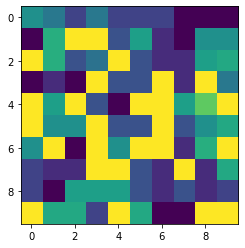

In [ ]:

import matplotlib.pyplot as plt

# CANAL ROJO
# ==========
#dibujo_r = pd.array(df[nombre_columnas_ROJO].iloc[0]).reshape(size,size)
#plt.imshow(dibujo_r)
#plt.show()


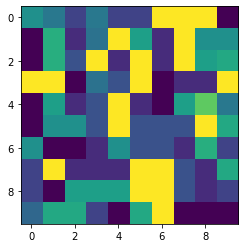

In [ ]:

# CANAL VERDE
# ===========
#dibujo_v = pd.array(df[nombre_columnas_VERDE].iloc[0]).reshape(size,size)
#plt.imshow(dibujo_v)
#plt.show()


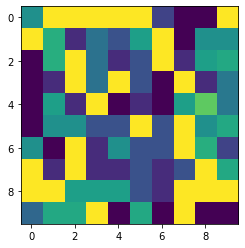

In [ ]:

# CANAL AZUL
# ==========
#dibujo_a = pd.array(df[nombre_columnas_AZUL].iloc[0]).reshape(size,size)
#plt.imshow(dibujo_a)
#plt.show()


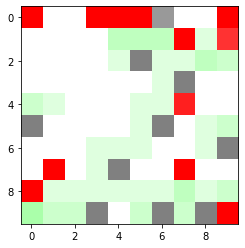

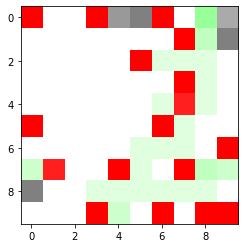

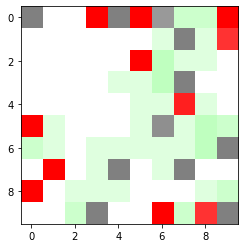

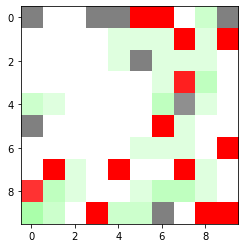

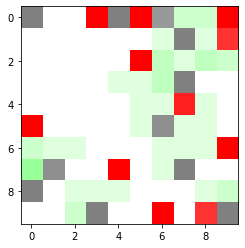

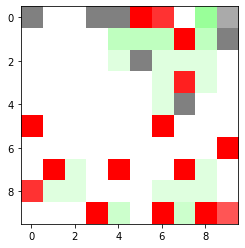

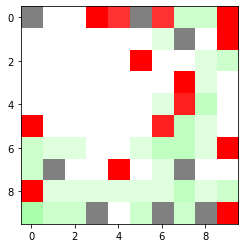

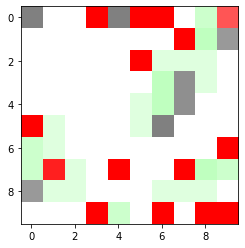

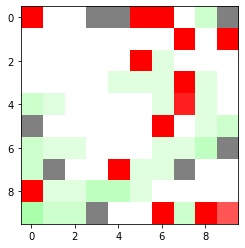

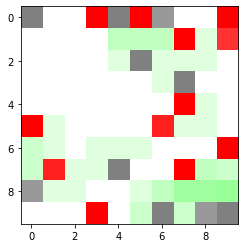

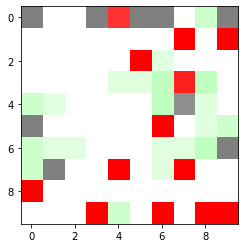

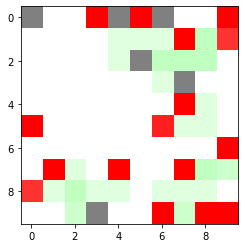

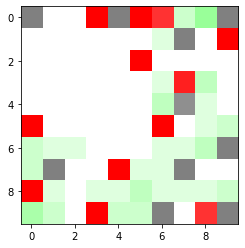

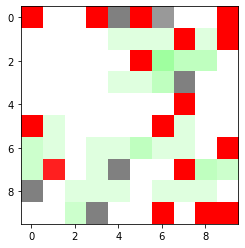

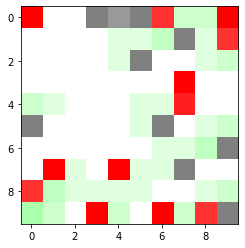

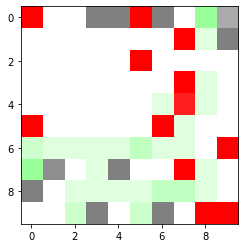

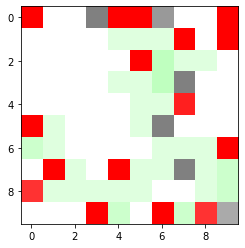

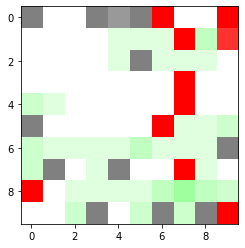

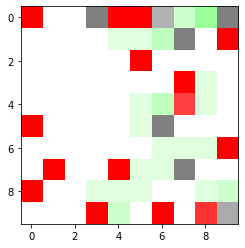

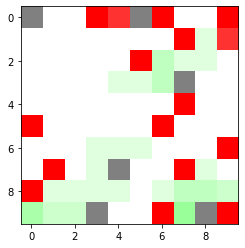

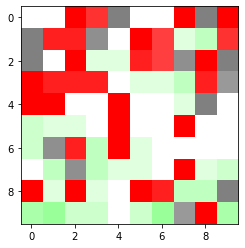

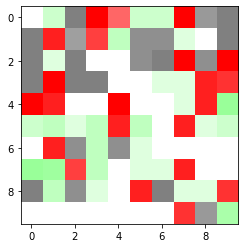

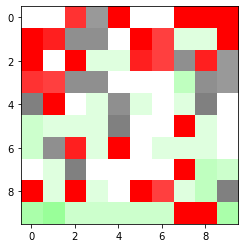

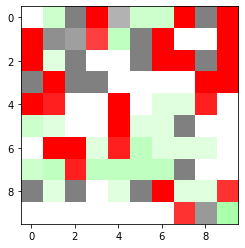

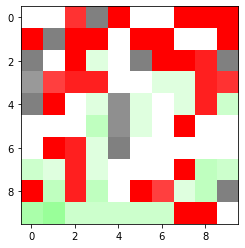

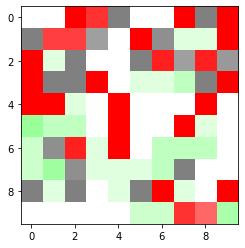

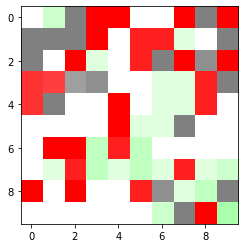

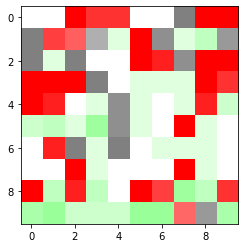

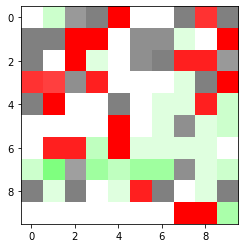

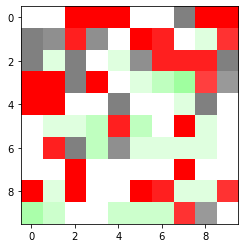

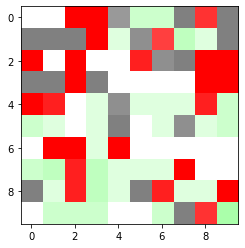

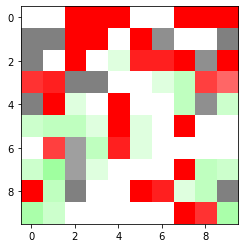

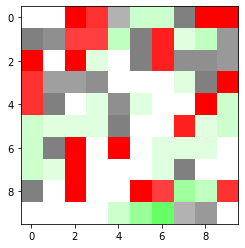

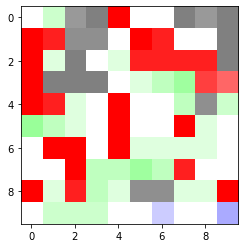

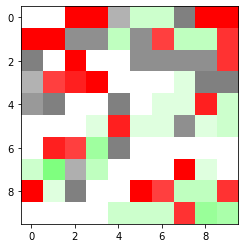

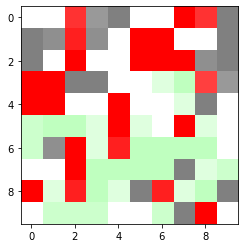

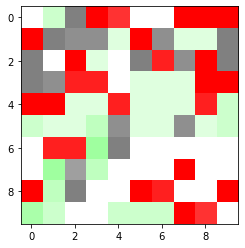

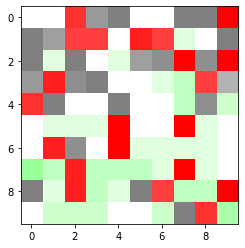

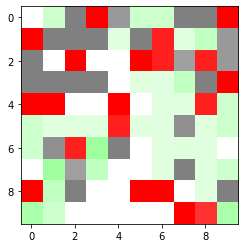

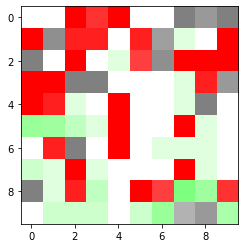

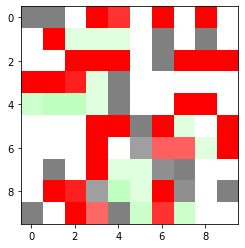

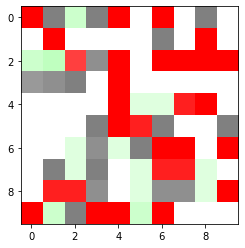

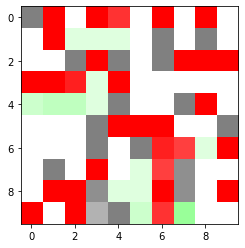

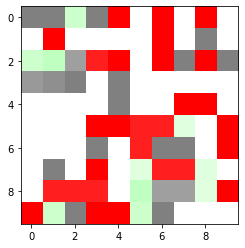

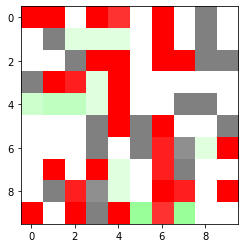

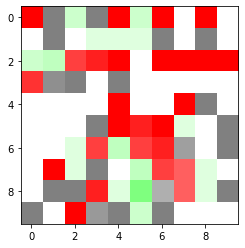

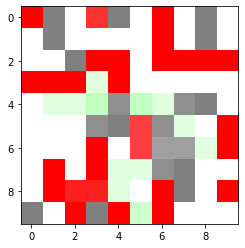

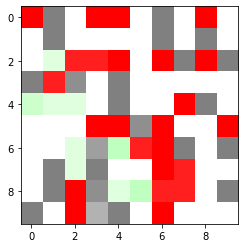

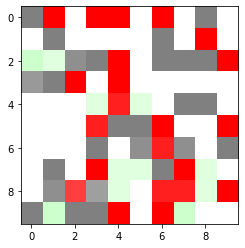

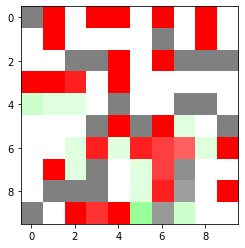

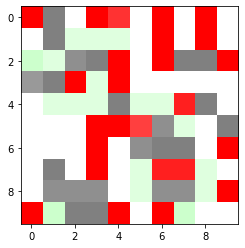

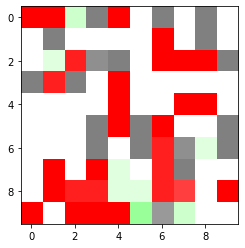

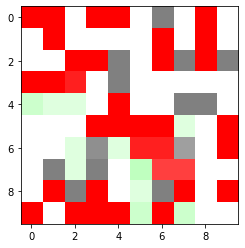

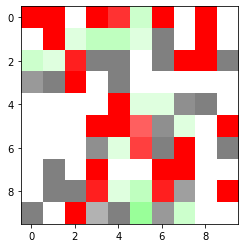

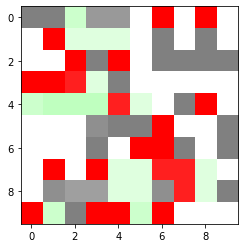

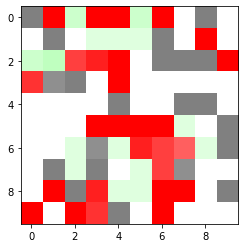

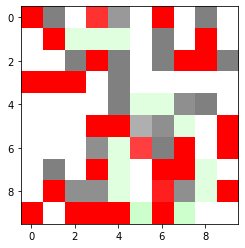

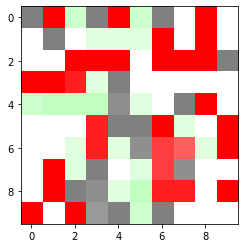

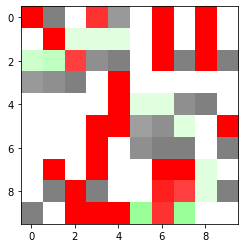

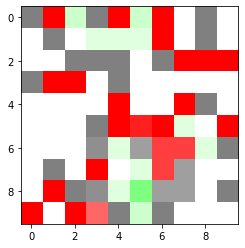

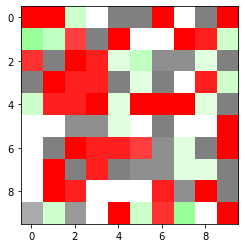

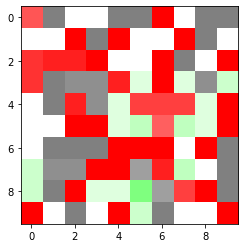

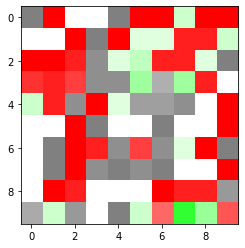

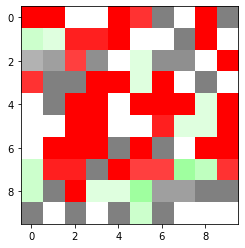

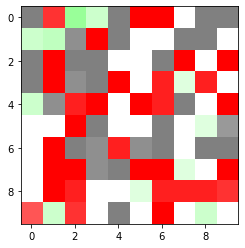

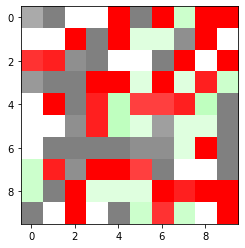

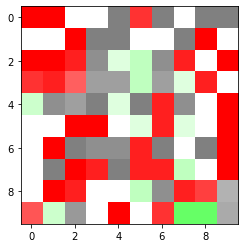

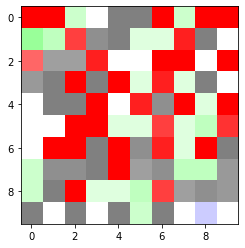

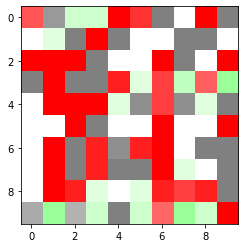

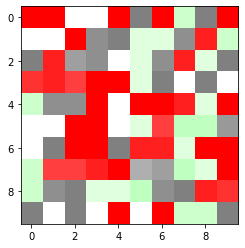

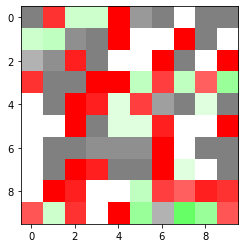

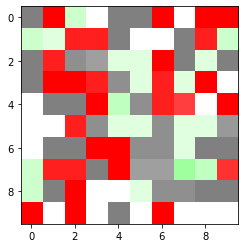

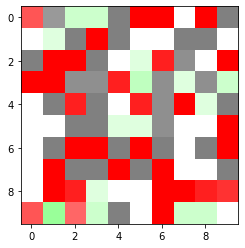

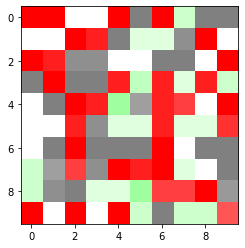

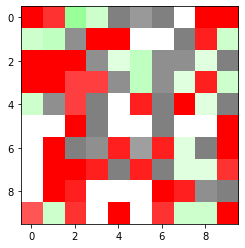

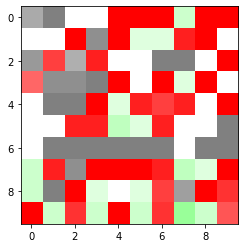

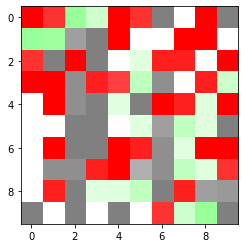

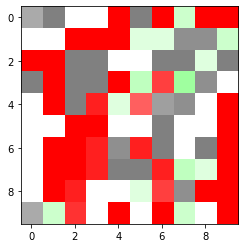

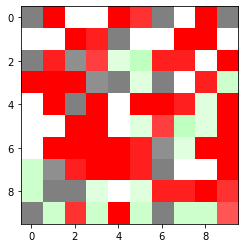

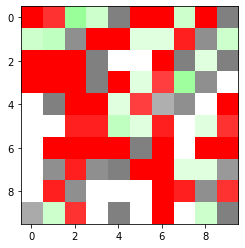

In [ ]:

import matplotlib.pyplot as plt

for agente in range(NUM_SIMULACIONES*NUM_FRAMES):
  dibujo_r = pd.array(df[nombre_columnas_ROJO].iloc[agente]).reshape(size,size)
  dibujo_v = pd.array(df[nombre_columnas_VERDE].iloc[agente]).reshape(size,size)
  dibujo_a = pd.array(df[nombre_columnas_AZUL].iloc[agente]).reshape(size,size)

  frame = np.dstack((dibujo_r, dibujo_v, dibujo_a))
  plt.imshow(frame)
  plt.show()


#GUARDANDO EL **DATA FRAME** EN UN ARCHIVO csv.

In [ ]:
import pandas as pd 

df.to_csv("bd_simulaciones.csv", index=None)


#LEYENDO EL **DATA FRAME** DEL ARCHIVO csv.

In [ ]:

datos = pd.read_csv('bd_simulaciones.csv')
datos


,r0,r1,r2,r3,r4,r5,r6,r7,r8,r9,...,b93,b94,b95,b96,b97,b98,b99,Simulacion_ID,Frame,Target
0,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,0.601569,1.0,1.0,1.000000,...,0.501961,1.000000,0.8,0.501961,0.8,0.501961,0.000000,1,1,1
1,1.000000,1.000000,1.0,1.000000,0.601569,0.501961,1.000000,1.0,0.6,0.667974,...,0.000000,0.800000,1.0,0.000000,1.0,0.000000,0.000000,1,2,1
2,0.501961,1.000000,1.0,1.000000,0.501961,1.000000,0.601569,0.8,0.8,1.000000,...,0.501961,1.000000,1.0,0.000000,0.8,0.200000,0.501961,1,3,1
3,0.501961,1.000000,1.0,0.501961,0.501961,1.000000,1.000000,1.0,0.8,0.501961,...,0.000000,0.800000,0.8,0.501961,1.0,0.000000,0.000000,1,4,1
4,0.501961,1.000000,1.0,1.000000,0.501961,1.000000,0.601569,0.8,0.8,1.000000,...,0.501961,1.000000,1.0,0.000000,1.0,0.200000,0.501961,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.667974,0.501961,1.0,1.000000,1.000000,1.000000,1.000000,0.8,1.0,1.000000,...,0.800000,0.000000,0.8,0.200000,0.6,0.800000,0.333333,4,16,1
76,1.000000,1.000000,0.6,0.800000,1.000000,1.000000,0.501961,1.0,1.0,0.501961,...,1.000000,0.501961,1.0,0.200000,0.8,0.600000,0.501961,4,17,1
77,0.667974,0.501961,1.0,1.000000,1.000000,0.501961,1.000000,0.8,1.0,1.000000,...,1.000000,0.000000,1.0,0.000000,0.8,1.000000,0.000000,4,18,1
78,0.501961,1.000000,1.0,1.000000,1.000000,1.000000,0.501961,1.0,1.0,0.501961,...,0.800000,0.000000,0.8,0.501961,0.8,0.800000,0.333333,4,19,1
